<a href="https://www.kaggle.com/code/dalao1002/house-prices-regression-prediction?scriptVersionId=154289955" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import platform
import sys

# linear algebra
import numpy as np
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
# plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning
import sklearn
import xgboost as xgb
import optuna

In [2]:
print("Operating system: ", platform.platform(), platform.version())
print("Python version", sys.version)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Matplotlib version: ", matplotlib.__version__)
print("Seaborn version: ", sns.__version__)
print("Sklearn version: ", sklearn.__version__)
print("XGBoost version: ", xgb.__version__)
print("Optuna version: ", optuna.__version__)

Operating system:  Linux-5.15.133+-x86_64-with-glibc2.31 #1 SMP Fri Dec 1 13:04:48 UTC 2023
Python version 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
Numpy version:  1.24.3
Pandas version:  2.0.3
Matplotlib version:  3.7.4
Seaborn version:  0.12.2
Sklearn version:  1.2.2
XGBoost version:  2.0.2
Optuna version:  3.4.0


In [3]:
# global configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sklearn.set_config(transform_output="pandas")

In [4]:
# Read the input data that are available in the read-only "../input/" directory
dataset_train_full_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
X_test_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')

In [5]:
TARGET = "SalePrice"
RANDOM_STATE = 0
HIGH_CARDINALITY_THRESHOLD = 10
TRAIN_VS_VALIDATION_SET_PERCENTANGE = 0.8
MISSING_VALUE_PLACEHOLDER = "Unkonwn"

In [6]:
# Remove rows with missing target
dataset_train_full_df.dropna(axis=0, subset=[TARGET], inplace=True)

# Separate target from features
X_train_full_df = dataset_train_full_df.drop([TARGET], axis=1)
y_train_full_s = dataset_train_full_df[TARGET]

In [7]:
from sklearn.model_selection import train_test_split

# Break off validation set from training data
X_train_df, X_valid_df, y_train_s, y_valid_s = train_test_split(
    X_train_full_df, y_train_full_s,
    train_size=TRAIN_VS_VALIDATION_SET_PERCENTANGE,
    # shuffle the dataset to ensure the traning set is representive of the overall distribution of the data,
    # this would be useful e.g. the input is sorted by target label or specific feature.
    shuffle=True,
    random_state=RANDOM_STATE
)

In [8]:
# display descriptive statistics
X_train_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1168.000000,956.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1162.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1110.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,56.605308,69.614017,10589.672945,6.086473,5.572774,1970.890411,1984.692637,103.481067,439.890411,45.571918,568.049658,1053.511986,1160.958904,351.479452,6.444349,1518.882705,0.422089,0.054795,1.566781,0.384418,2.882705,1.044521,6.544521,0.612158,1978.140541,1.771404,473.632705,94.498288,48.044521,23.022260,3.218322,14.528253,2.118151,50.936644,6.301370,2007.819349
std,42.172322,22.946069,10704.180793,1.367472,1.116908,30.407486,20.684612,182.676225,435.106803,156.229962,437.569919,412.073393,373.315037,438.137938,51.200836,513.800708,0.514494,0.231409,0.546698,0.497118,0.802166,0.218441,1.624493,0.640872,24.877265,0.730041,209.442320,127.312017,68.619199,63.153093,27.916593,54.009608,36.482294,550.380636,2.725977,1.335971
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7589.500000,5.000000,5.000000,1953.750000,1966.000000,0.000000,0.000000,0.000000,228.000000,798.750000,884.000000,0.000000,0.000000,1139.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9512.500000,6.000000,5.000000,1972.000000,1993.000000,0.000000,379.500000,0.000000,482.500000,992.000000,1092.000000,0.000000,0.000000,1471.500000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,477.500000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,167.750000,716.000000,0.000000,811.250000,1276.250000,1389.250000,729.000000,0.000000,1788.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1120.000000,2153.000000,3206.000000,3228.000000,1872.000000,572.000000,4676.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1390.000000,736.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [9]:
# display sample data
X_train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
619,20,RL,90.0,11694,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2007,2007,Hip,CompShg,CemntBd,CmentBd,BrkFace,452.0,Ex,TA,PConc,Ex,TA,Av,GLQ,48,Unf,0,1774,1822,GasA,Ex,Y,SBrkr,1828,0,0,1828,0,0,2,0,3,1,Gd,9,Typ,1,Gd,Attchd,2007.0,Unf,3,774,TA,TA,Y,0,108,0,0,260,0,NaN,NaN,NaN,0,7,2007,New,Partial
871,20,RL,60.0,6600,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,PosN,Norm,1Fam,1Story,5,5,1962,1962,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,894,894,GasA,Gd,N,SBrkr,894,0,0,894,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1962.0,Unf,1,308,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal
93,30,RL,80.0,13360,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1Story,5,7,1921,2006,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,Gd,BrkTil,Gd,TA,No,ALQ,713,Unf,0,163,876,GasA,Ex,Y,SBrkr,964,0,0,964,1,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1921.0,Unf,2,432,TA,TA,Y,0,0,44,0,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal
818,20,RL,NaN,13265,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,1Story,8,5,2002,2002,Hip,CompShg,CemntBd,CmentBd,BrkFace,148.0,Gd,TA,PConc,Gd,TA,No,GLQ,1218,Unf,0,350,1568,GasA,Ex,Y,SBrkr,1689,0,0,1689,1,0,2,0,3,1,Gd,7,Typ,2,Gd,Attchd,2002.0,RFn,3,857,TA,TA,Y,150,59,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal
303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,150.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1541,1541,GasA,Ex,Y,SBrkr,1541,0,0,1541,0,0,2,0,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,3,843,TA,TA,Y,468,81,0,0,0,0,NaN,NaN,NaN,0,1,2006,WD,Normal


In [10]:
# sort features by number of missing values
X_train_df.loc[:, X_train_df.isnull().any()].isnull().sum().sort_values(ascending=False)

PoolQC          1164
MiscFeature     1119
Alley           1097
Fence            954
MasVnrType       707
FireplaceQu      551
LotFrontage      212
GarageType        58
GarageYrBlt       58
GarageFinish      58
GarageQual        58
GarageCond        58
BsmtFinType2      29
BsmtFinType1      28
BsmtExposure      28
BsmtCond          28
BsmtQual          28
MasVnrArea         6
Electrical         1
dtype: int64

In [11]:
# find correlation between features
correlation = X_train_df.corr(numeric_only=True).unstack().sort_values(kind="quicksort", ascending=False)

correlation = correlation[correlation!=1]
print("Top 20 with highest positive correlation")
print(correlation[:20])
print()
print("Top 20 with highest negative correlation")
print(correlation[-20:][::-1])

Top 20 with highest positive correlation
GarageCars    GarageArea      0.887174
GarageArea    GarageCars      0.887174
TotRmsAbvGrd  GrLivArea       0.829416
GrLivArea     TotRmsAbvGrd    0.829416
YearBuilt     GarageYrBlt     0.822975
GarageYrBlt   YearBuilt       0.822975
1stFlrSF      TotalBsmtSF     0.795440
TotalBsmtSF   1stFlrSF        0.795440
GrLivArea     2ndFlrSF        0.699098
2ndFlrSF      GrLivArea       0.699098
TotRmsAbvGrd  BedroomAbvGr    0.680987
BedroomAbvGr  TotRmsAbvGrd    0.680987
BsmtFullBath  BsmtFinSF1      0.658004
BsmtFinSF1    BsmtFullBath    0.658004
GarageYrBlt   YearRemodAdd    0.649385
YearRemodAdd  GarageYrBlt     0.649385
FullBath      GrLivArea       0.640448
GrLivArea     FullBath        0.640448
TotRmsAbvGrd  2ndFlrSF        0.618986
2ndFlrSF      TotRmsAbvGrd    0.618986
dtype: float64

Top 20 with highest negative correlation
BsmtFinSF1     BsmtUnfSF       -0.524498
BsmtUnfSF      BsmtFinSF1      -0.524498
               BsmtFullBath    -0.437367

In [12]:
# display correlation with our target
print(X_train_df.corrwith(y_train_s, numeric_only=True).sort_values(kind="quicksort", ascending=False))

OverallQual      0.790636
GrLivArea        0.721707
GarageCars       0.660927
GarageArea       0.646603
TotalBsmtSF      0.635535
1stFlrSF         0.620740
FullBath         0.578134
TotRmsAbvGrd     0.542658
YearBuilt        0.521242
YearRemodAdd     0.517822
GarageYrBlt      0.494154
MasVnrArea       0.493482
Fireplaces       0.470320
BsmtFinSF1       0.401390
LotFrontage      0.360274
OpenPorchSF      0.320193
2ndFlrSF         0.320141
WoodDeckSF       0.311813
HalfBath         0.283762
LotArea          0.252766
BsmtFullBath     0.226432
BsmtUnfSF        0.206736
BedroomAbvGr     0.182258
ScreenPorch      0.096740
3SsnPorch        0.057561
MoSold           0.041369
PoolArea         0.027441
BsmtHalfBath    -0.010994
BsmtFinSF2      -0.020622
LowQualFinSF    -0.023128
MiscVal         -0.024750
YrSold          -0.045628
OverallCond     -0.053643
MSSubClass      -0.084312
EnclosedPorch   -0.129519
KitchenAbvGr    -0.136104
dtype: float64


In [13]:
all_cols = X_train_df.columns

# manually select the additional nominative (unordered) categorical features
manual_nominal_cols = [
    "MSSubClass"
]
# manually select the ordinal (ordered) categorical features
ordinal_cols = [
    "OverallQual",
    "OverallCond",
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
    "PoolQC",
    "LotShape",
    "LandSlope",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "GarageFinish",
    "PavedDrive",
    "Utilities",
    "CentralAir",
    "Electrical",
    "Fence"
]

# automatically select nominal variables
auto_nominal_cols = [cname for cname in all_cols if ((X_train_df[cname].dtype == "object") and (cname not in ordinal_cols))]
# merge nominal variables
nominal_cols = manual_nominal_cols + auto_nominal_cols
# Select relatively low cardinality variables (cardinality means the number of unique values in a column)
low_cardinality_nominal_cols = [cname for cname in nominal_cols if 
                                     X_train_df[cname].nunique() < HIGH_CARDINALITY_THRESHOLD]
# Select relatively high cardinality variables
high_cardinality_nominal_cols = [cname for cname in nominal_cols if 
                                     X_train_df[cname].nunique() >= HIGH_CARDINALITY_THRESHOLD and
                                     cname not in low_cardinality_nominal_cols]
# union all categorial data
categorical_cols = nominal_cols + ordinal_cols

In [14]:
# Select continuous variables columns
continuous_cols = [cname for cname in all_cols if X_train_df[cname].dtype in ['float', 'float64'] and cname not in categorical_cols]
# Select dicrete variables
discrete_cols = [cname for cname in all_cols if X_train_df[cname].dtype in ['int', 'int64'] and cname not in categorical_cols]
# Combine as numerical columns
numerical_cols = continuous_cols + discrete_cols

In [15]:
assert len(all_cols) == len(categorical_cols + numerical_cols)

In [16]:
X_train_df[high_cardinality_nominal_cols].nunique()

MSSubClass      15
Neighborhood    25
Exterior1st     15
Exterior2nd     16
dtype: int64

In [17]:
X_train_df[high_cardinality_nominal_cols].isnull().sum()

MSSubClass      0
Neighborhood    0
Exterior1st     0
Exterior2nd     0
dtype: int64

In [18]:
X_train_df[high_cardinality_nominal_cols].isna().sum()

MSSubClass      0
Neighborhood    0
Exterior1st     0
Exterior2nd     0
dtype: int64

In [19]:
for col in high_cardinality_nominal_cols:
    print(X_train_df[col].value_counts())

MSSubClass
20     430
60     243
50     115
120     68
30      56
160     53
70      49
80      44
90      38
190     24
75      14
85      14
45      11
180      6
40       3
Name: count, dtype: int64
Neighborhood
NAmes      177
CollgCr    116
OldTown     89
Edwards     80
Somerst     68
Sawyer      65
Gilbert     64
NridgHt     61
NWAmes      56
SawyerW     46
BrkSide     46
Mitchel     42
Crawfor     40
Timber      34
NoRidge     33
IDOTRR      29
ClearCr     26
SWISU       22
StoneBr     17
MeadowV     14
Blmngtn     13
BrDale      12
Veenker      8
NPkVill      8
Blueste      2
Name: count, dtype: int64
Exterior1st
VinylSd    412
Wd Sdng    175
HdBoard    171
MetalSd    164
Plywood     94
CemntBd     50
BrkFace     42
WdShing     21
Stucco      17
AsbShng     16
Stone        2
AsphShn      1
BrkComm      1
ImStucc      1
CBlock       1
Name: count, dtype: int64
Exterior2nd
VinylSd    401
Wd Sdng    169
MetalSd    160
HdBoard    160
Plywood    123
CmentBd     50
Wd Shng     30
BrkF

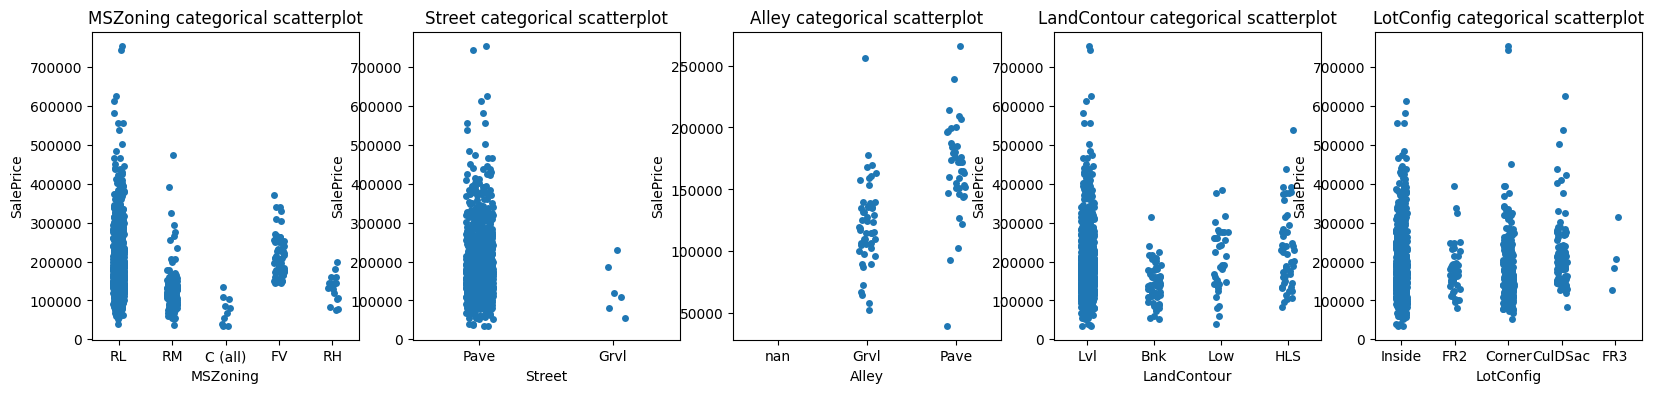

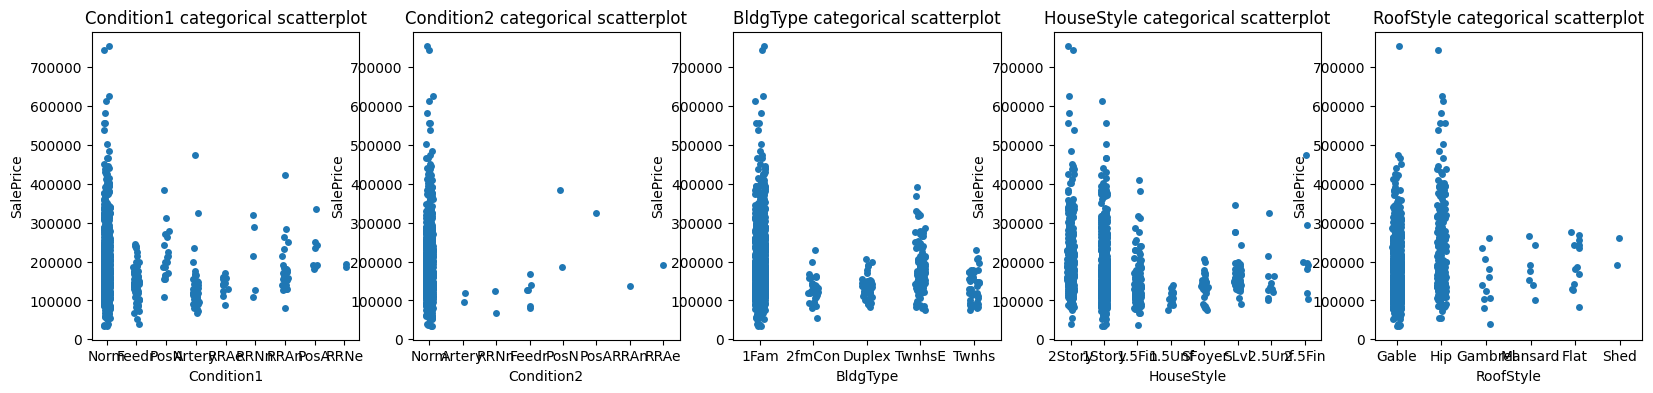

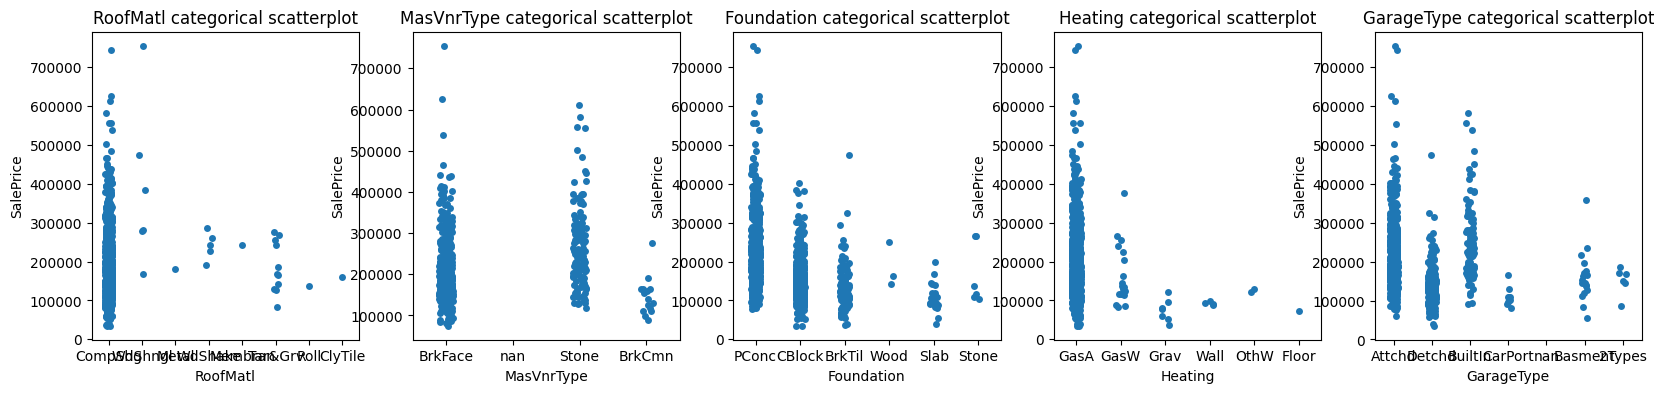

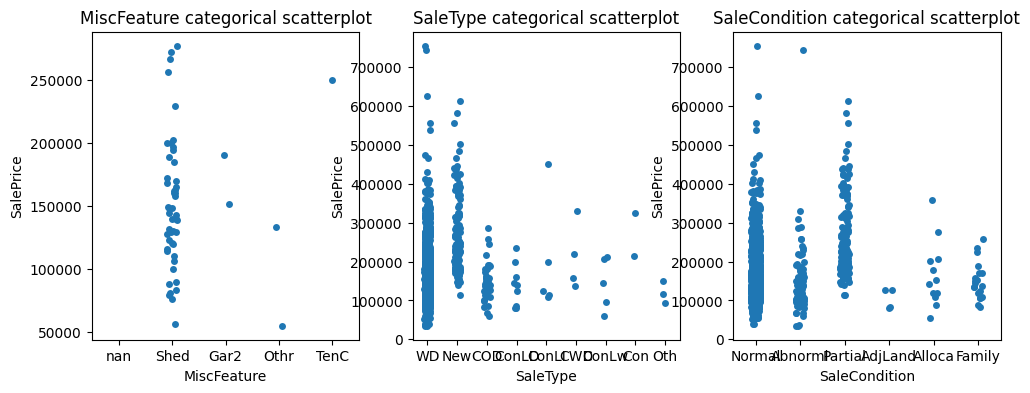

In [20]:
from itertools import zip_longest

# Draw bar plots of all the categorical columns
for sub_categirical_cols in zip_longest(*[iter(low_cardinality_nominal_cols)] * 5, fillvalue=None):
    fig = plt.figure(figsize = (20, 4))
    for index, categirical_col in enumerate(sub_categirical_cols, start=1):
        if categirical_col:
            ax = fig.add_subplot(1, 5, index)
            sns.stripplot(data=dataset_train_full_df, x=categirical_col, y=TARGET, ax=ax)
            ax.set_title(categirical_col + " categorical scatterplot")

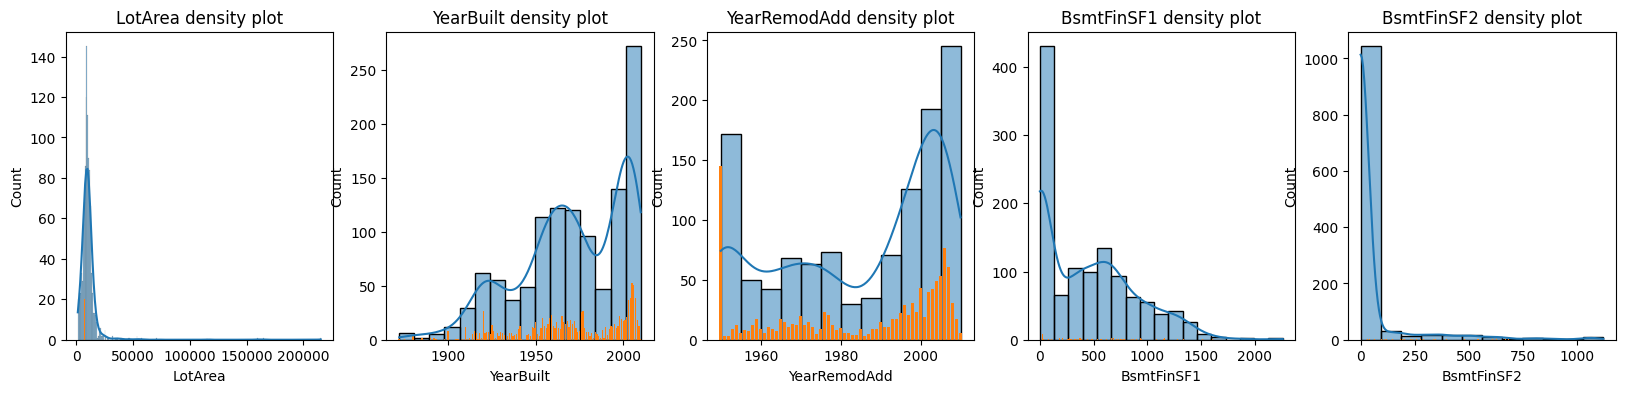

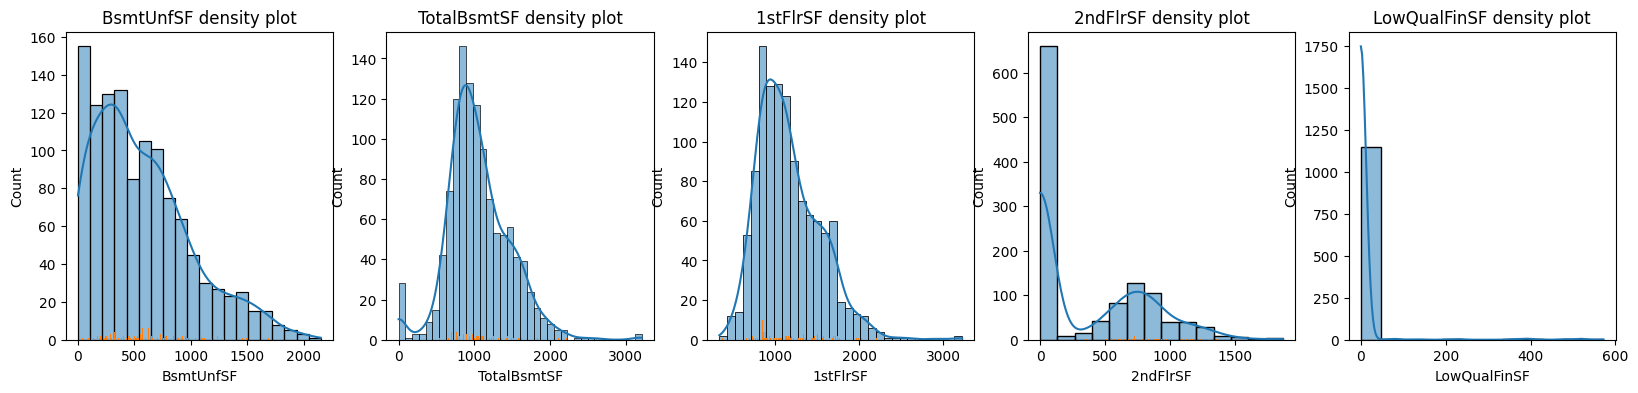

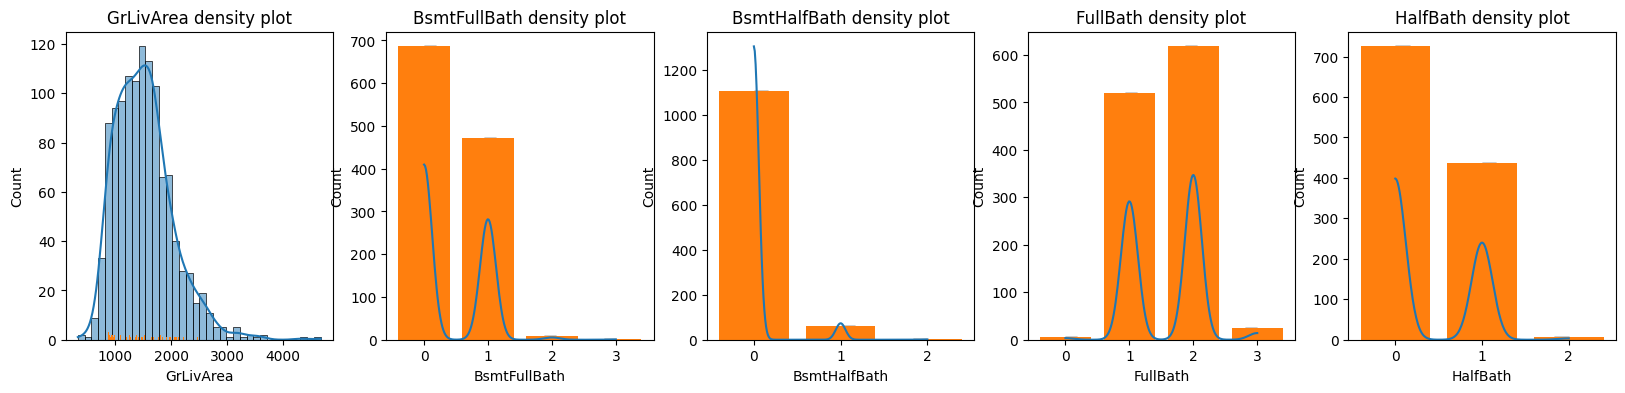

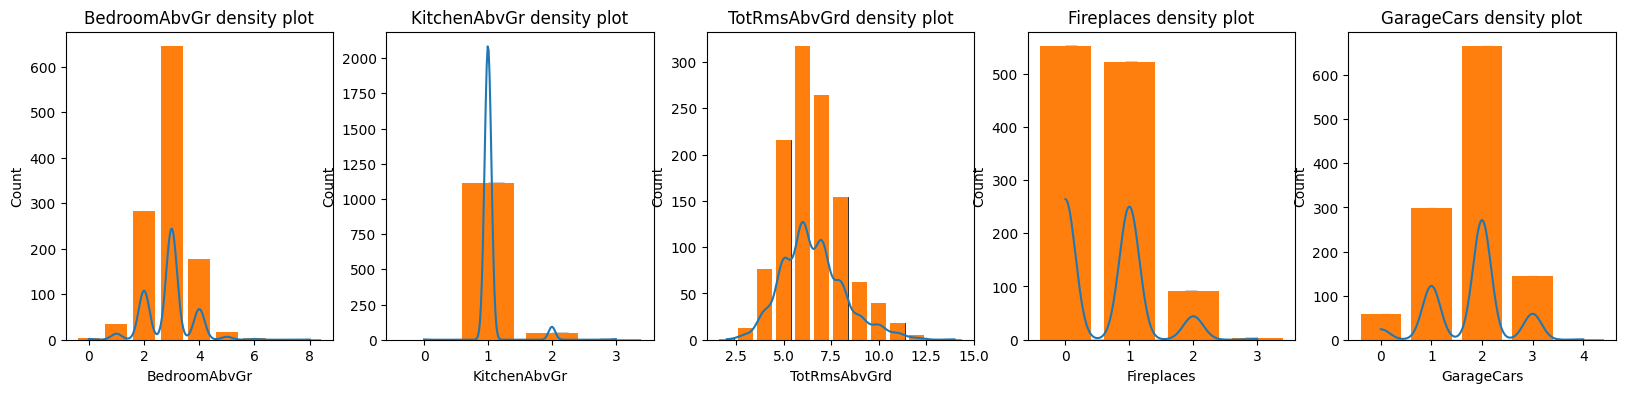

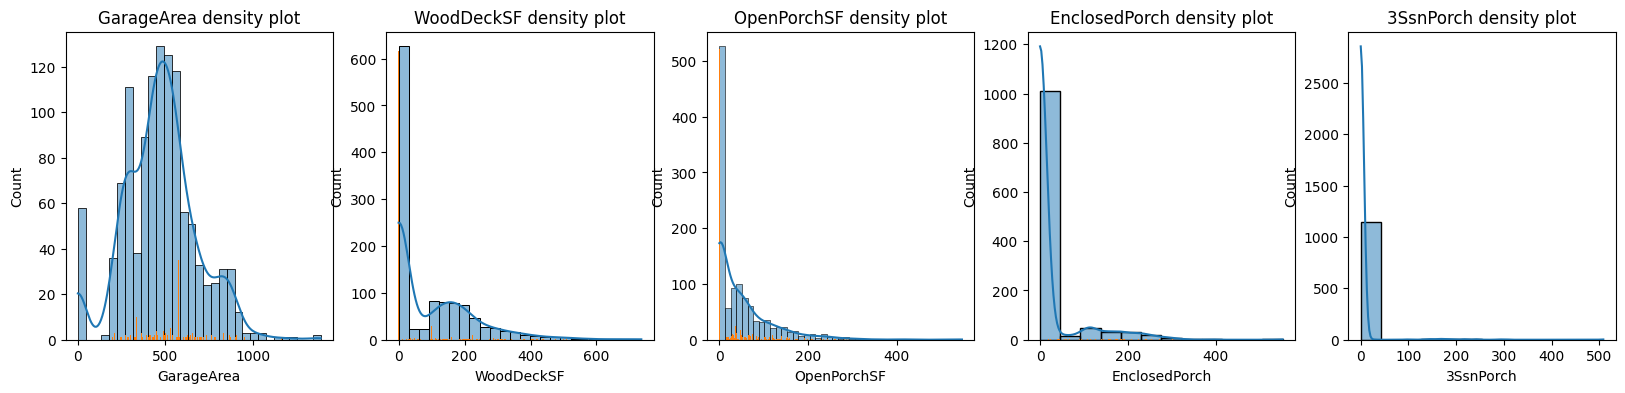

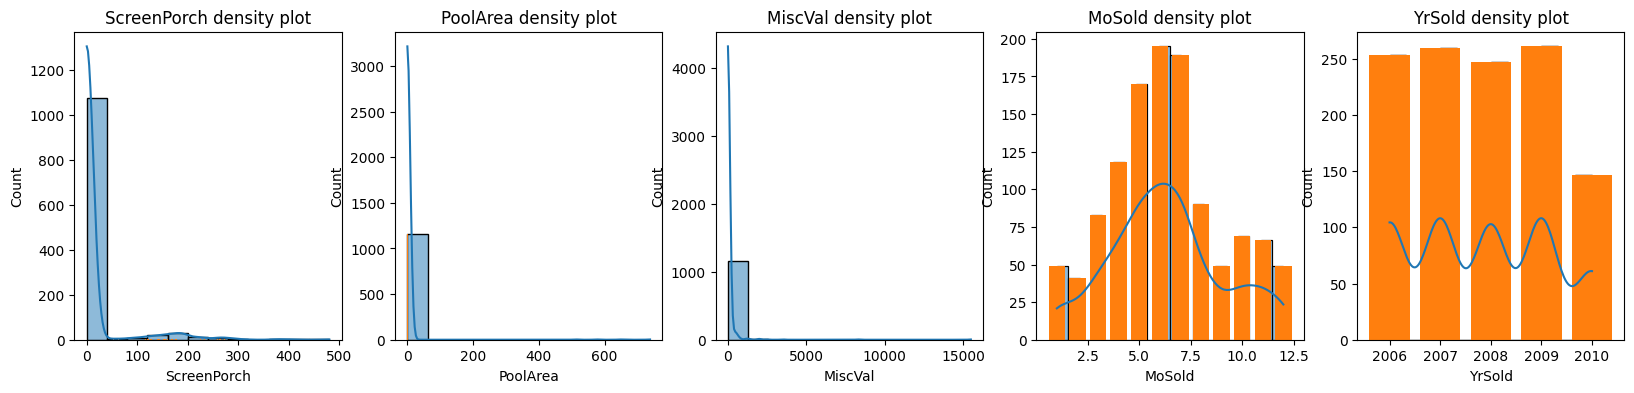

In [21]:
from itertools import zip_longest

# Draw bar plots of all the discrete columns
for sub_discrete_cols in zip_longest(*[iter(discrete_cols)] * 5, fillvalue=None):
    fig = plt.figure(figsize = (20, 4))
    for index, discrete_col in enumerate(sub_discrete_cols, start=1):
        if discrete_col:
            counts = X_train_df[discrete_col].value_counts()
            ax = fig.add_subplot(1, 5, index)
            sns.histplot(X_train_df[discrete_col], ax=ax, kde=True)
            ax.bar(counts.index, height=counts.values)
            ax.set_title(discrete_col + " density plot")

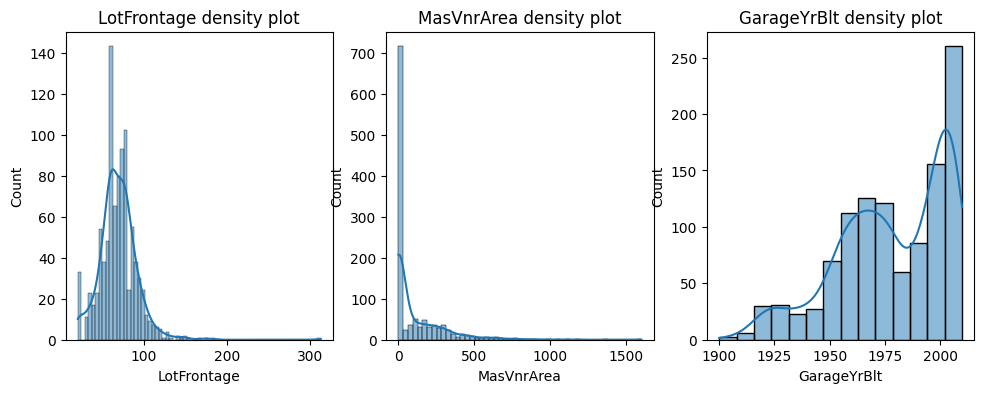

In [22]:
from itertools import zip_longest

# Draw bar plots of all the continuous columns
for sub_continuous_cols in zip_longest(*[iter(continuous_cols)] * 5, fillvalue=None):
    fig = plt.figure(figsize = (20, 4))
    for index, continuous_col in enumerate(sub_continuous_cols, start=1):
        if continuous_col:
            counts = X_train_df[continuous_col].value_counts()
            ax = fig.add_subplot(1, 5, index)
            sns.histplot(X_train_df[continuous_col], ax=ax, kde=True)
            ax.set_title(continuous_col + " density plot")

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler
from category_encoders import LeaveOneOutEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

In [24]:
# Data Cleaning

def fix_garage_built_year(df):
    """
    some values of GarageYrBlt are corrupt,
    so we'll replace them with the year the house was built
    """
    df["GarageYrBlt"].fillna(df.YearBuilt, inplace=True)
    return df

features_cleaning_pipeline = Pipeline(steps=[
    ('make_copy', FunctionTransformer(lambda dt: dt.copy())),
    ('fix_garage_built_year', FunctionTransformer(fix_garage_built_year))
])

In [25]:
# Data Imputing

continuous_features_imputer = SimpleImputer(strategy="mean")
discrete_features_imputer = SimpleImputer(strategy="median")
ordinal_features_imputer = SimpleImputer(strategy="constant", fill_value=MISSING_VALUE_PLACEHOLDER)

features_imputing_column_transformer = ColumnTransformer(
    transformers = [
        # The order of the columns in the transformed feature matrix
        # follows the order of how the columns are specified in the transformers list.
        ('continuous_features_imputer', continuous_features_imputer, continuous_cols),
        ('discrete_features_imputer', discrete_features_imputer, discrete_cols),
        ('ordinal_features_imputer', ordinal_features_imputer, ordinal_cols)
    ],
    remainder = "passthrough",
    verbose_feature_names_out = False
)

In [26]:
# Data Encoding

## numerical features
standard_scaler = StandardScaler()
pca = PCA()
numerical_features_encoder = Pipeline(steps=[
    ("standard_scaler", standard_scaler),
    # PCA only works with numeric features, like continuous quantities or counts.
    # PCA is sensitive to scale.
    # It's good practice to standardize your data before applying PCA,
    # unless you know you have good reason not to.
    ('pca', pca),
])

## categorical features
### ordinal features
ten_levels = list(range(1, 10 + 1))
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
features_to_levels_map = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}
#### add a placeholder level for missing values
features_to_levels_map = {key: [MISSING_VALUE_PLACEHOLDER] + value for key, value in features_to_levels_map.items()}
ordinal_features_encoder = OrdinalEncoder(categories=[features_to_levels_map[cname] for cname in ordinal_cols], handle_unknown='error')
### nominal features
#### low cardinality
low_cardinality_nominal_features_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
#### high cardinality
high_cardinality_nominal_features_encoder = LeaveOneOutEncoder()

# bundle
features_encoding_column_transformer = ColumnTransformer(
    transformers = [
        ('numerical_features_encoder', numerical_features_encoder, numerical_cols),
        ('ordinal_features_encoder', ordinal_features_encoder, ordinal_cols),
        ('low_cardinality_nominal_features_encoder', low_cardinality_nominal_features_encoder, low_cardinality_nominal_cols),
        # ('high_cardinality_nominal_features_encoder', high_cardinality_nominal_features_encoder, high_cardinality_nominal_cols),
    ],
    remainder = "drop",
    verbose_feature_names_out = False
)

In [27]:
preprocessing_pipeline = Pipeline(steps=[
    ('data_cleaning_pipeline', features_cleaning_pipeline),
    ('features_imputing_column_transformer', features_imputing_column_transformer),
    ('features_encoding_column_transformer', features_encoding_column_transformer)
])

In [28]:
preprocessing_pipeline.fit(X_train_df, y=y_train_s)

Pipeline(steps=[('data_cleaning_pipeline',
                 Pipeline(steps=[('make_copy',
                                  FunctionTransformer(func=<function <lambda> at 0x7d6282e1db40>)),
                                 ('fix_garage_built_year',
                                  FunctionTransformer(func=<function fix_garage_built_year at 0x7d628f0dadd0>))])),
                ('features_imputing_column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('continuous_featu...
                                                 ('low_cardinality_nominal_features_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LandContour',
                                                   'LotConfig', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'MasVnrType',
                                                   'Foundation', 'Heating',
                                                   'GarageType', 'MiscFeature',
                                                   'SaleType',
                                                   'SaleCondition'])],
                                   verbose_feature_names_out=False))])

In [29]:
preprocessing_pipeline.transform(X_train_df)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,LotShape,LandSlope,BsmtExposure,BsmtFinType1,BsmtFinType2,Functional,GarageFinish,PavedDrive,Utilities,CentralAir,Electrical,Fence,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_nan,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_nan,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_nan,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
619,4.377347,-0.099519,-0.093412,3.399111,-2.539474,-2.945790,-0.020245,0.738469,-0.650142,0.235082,0.184739,0.566702,-1.600410,0.771984,0.844711,-0.647215,-0.233252,0.272299,-0.687771,-0.020365,1.548682,0.821824,0.013810,0.107885,-0.742043,-0.044268,0.655386,-0.028549,-0.851750,0.081509,0.000063,-5.544017e-16,7.311794e-16,9.0,5.0,5.0,3.0,5.0,3.0,5.0,4.0,4.0,3.0,3.0,0.0,1.0,3.0,3.0,6.0,1.0,8.0,1.0,3.0,3.0,2.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
871,-3.288831,-0.396606,-0.863740,1.469205,-0.168643,-0.380451,-0.009100,-0.234997,0.090634,-0.112499,-0.152459,-0.092345,0.466758,0.312157,0.177308,-0.333673,-0.664321,-0.486959,0.307216,0.323179,0.012156,-0.536425,0.024766,-0.192931,0.464489,0.327161,0.351202,-0.225665,-0.177342,-0.051868,0.200186,-6.435731e-18,5.198507e-17,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,0.0,3.0,3.0,0.0,1.0,3.0,1.0,1.0,1.0,8.0,1.0,3.0,3.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
93,-2.523513,-1.490880,1.050444,-0.250772,0.639335,-0.032893,-0.303541,0.632509,0.613609,0.083128,

In [30]:
# Define the model
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.5,
    early_stopping_rounds=5,
    random_state=RANDOM_STATE,
    objective="reg:squarederror",
    # objective="reg:squaredlogerror",
    eval_metric="rmse",
    # eval_metric="rmsle",
)

In [31]:
X_train_transformed = preprocessing_pipeline.transform(X_train_df)
X_valid_transformed = preprocessing_pipeline.transform(X_valid_df)

In [32]:
# Fit the model
classifier = model.fit(
    X_train_transformed, y_train_s,
    # If there’s more than one item in eval_set, the last entry will be used for early stopping.
    eval_set=[(X_train_transformed, y_train_s), (X_valid_transformed, y_valid_s)],
    verbose=False
)

In [33]:
# Load evals result by calling the evals_result() function
evals_result = classifier.evals_result()

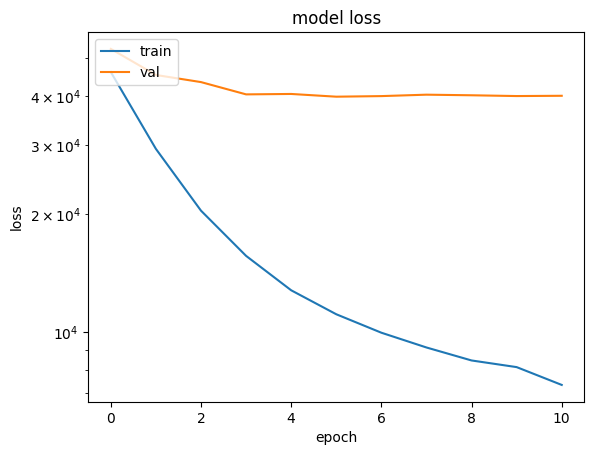

In [34]:
plt.plot(evals_result['validation_0']["rmse"])
plt.plot(evals_result['validation_1']["rmse"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.yscale('log')
plt.show()

In [35]:
# Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('model', model)
])

In [36]:
from sklearn.metrics import mean_squared_log_error

# Get predictions of training data, 
y_train_preds = pipeline.predict(X_train_df)

# Evaluate the model on training set
score_on_training_set = mean_squared_log_error(y_train_s, y_train_preds, squared=False)
print('RMSLE on training set:', score_on_training_set)

# Get predictions of validation data
y_valid_preds = pipeline.predict(X_valid_df)

# Evaluate the model on validation set
score_on_validation_set = mean_squared_log_error(y_valid_s, y_valid_preds, squared=False)
print('RMSLE on validation set:', score_on_validation_set)

RMSLE on training set: 0.07333061884436666
RMSLE on validation set: 0.1582731349596944


In [37]:
X_test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [38]:
# make predictions which we will submit. 
y_test_preds = pipeline.predict(X_test_df)

In [39]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Run the code to save predictions in the format used for competition scoring
output = pd.DataFrame({'Id': X_test_df.index, TARGET: y_test_preds})
output.to_csv('/kaggle/working/submission.csv', index=False)